## 前置处理

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: f'{x:.3f}')
# 设置pandas展示格式

In [2]:
#检查指定目录下的可用文件
import os
for root, dirs, files in os.walk("./data"):  
    print("\n".join(files)) #当前路径下所有非目录子文件

data_description.txt
sample_submission.csv
test.csv
train.csv


In [3]:
# 读取数据
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [4]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [7]:
# 删除特征中的ID,并保存下来
train_ID = train.loc[:,"Id"]
test_ID = test.loc[:,"Id"]
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

In [8]:
train.shape, test.shape

((1460, 80), (1459, 79))

## 数据预处理

### 异常值

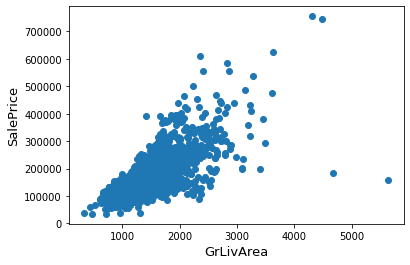

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = train["GrLivArea"], y = train["SalePrice"])
plt.ylabel("SalePrice", fontsize=13)
plt.xlabel("GrLivArea", fontsize=13)
plt.show()

可以看到右下角有两个点售价低，面积巨大

删除异常值

In [10]:
train = train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index)

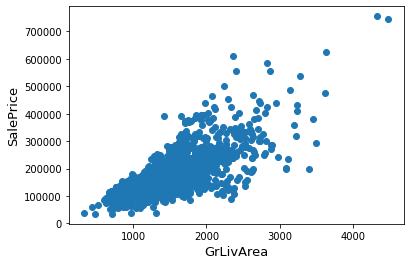

In [11]:
fig, ax = plt.subplots()
ax.scatter(x = train["GrLivArea"], y = train["SalePrice"])
plt.ylabel("SalePrice", fontsize=13)
plt.xlabel("GrLivArea", fontsize=13)
plt.show()

异常值的删除总不会错，所以删除这两个比较极端的值

训练数据里面可能还有其他异常值。但是，移除所有的异常值训练的模型并不是最好的（可能会过拟合），因为测试集里可能也存在异常的情况。所以我们要做的是是模型的泛化性能更好。

### 目标变量

In [12]:
print("".join([i for i in train.columns if i not in test.columns]))

SalePrice


SalePrice是我们的目标变量，我们应该首先分析他。


 mu = 180932.92 and sigma = 79467.79


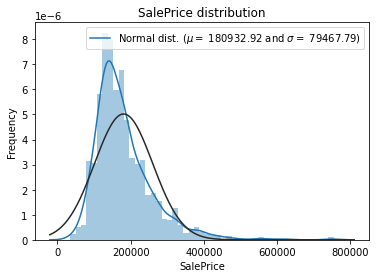

In [13]:
sns.distplot(train["SalePrice"], fit=norm)

# 得到高斯分布拟合参数
mu, sigma = norm.fit(train["SalePrice"])
print(f"\n mu = {mu:.2f} and sigma = {sigma:.2f}")

# 现在画出分布的图注等
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f})'],
          loc="best")
plt.ylabel("Frequency")
plt.title("SalePrice distribution")
plt.show()

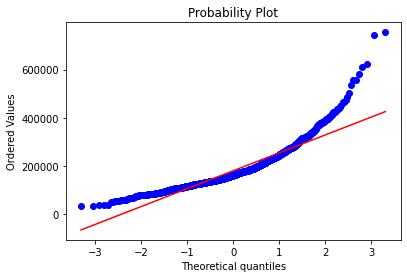

In [14]:
# 画出QQ图
fig = plt.figure()
res = stats.probplot(train["SalePrice"], plot=plt)
plt.show()

正态分布是自然界中广泛存在的，我们都知道它是两头低，中间高，整个形态呈现对称钟形的一个分布，之所以叫正态分布，是因为在大量连续数据测量的情况下，我们比较希望看到这种状态，一个标准的正态分布是u（均值）=0，σ（标准差）=1。

从下图可以看出，横坐标代表随机变量X的一个取值，在均值（u=0）附近概率密度最大，越偏离均值，概率密度减小，不在(u-3σ,u+3σ)范围内的数据就属于统计学意义上的异常值了。
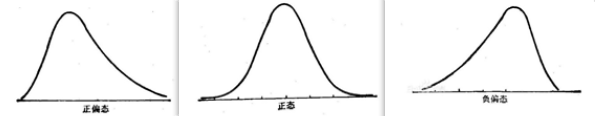

红色线条表示正态分布，蓝色线条表示样本数据，蓝色越接近红色参考线，说明越符合预期分布（也就是正态分布）
Q-Q图是通过比较数据和正态分布的分位数是否相等来判断数据是不是符合正态分布

我们发现目标变量右偏。因为（线性）模型喜欢正态分布的数据，我们需要处理变量使他成正态分布。


 mu = 12.02 and sigma = 0.40


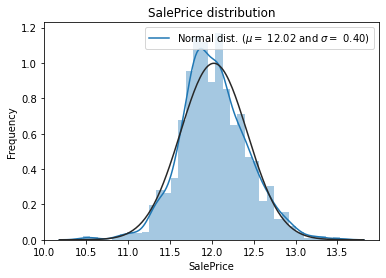

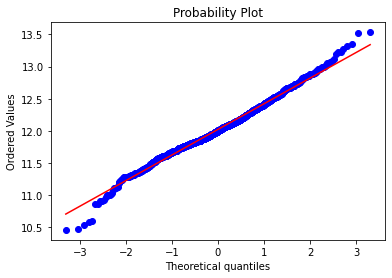

In [15]:
# 我们对目标变量使用log（1+x）来处理目标变量
train["SalePrice"] = np.log1p(train["SalePrice"])

# 继续查看新的分布
sns.distplot(train["SalePrice"], fit=norm)

# 得到高斯分布拟合参数
mu, sigma = norm.fit(train["SalePrice"])
print(f"\n mu = {mu:.2f} and sigma = {sigma:.2f}")

# 现在画出分布的图注等
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f})'],
          loc="best")
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

# 画出QQ图
fig = plt.figure()
res = stats.probplot(train["SalePrice"], plot=plt)
plt.show()

现在这种偏态得到了改正，数据基本符合正态分布了

## 特征工程

我们首先将训练集和测试放在同一个DataFrame中

In [16]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_trian = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
# 重新设置索引，drop不让索引单独多出一列特征
all_data.drop(['SalePrice'], axis=1, inplace=True)
print(f"all_data size is : {all_data.shape}")

all_data size is : (2917, 79)


### 缺失数据

In [17]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({"Missing Ratio" :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


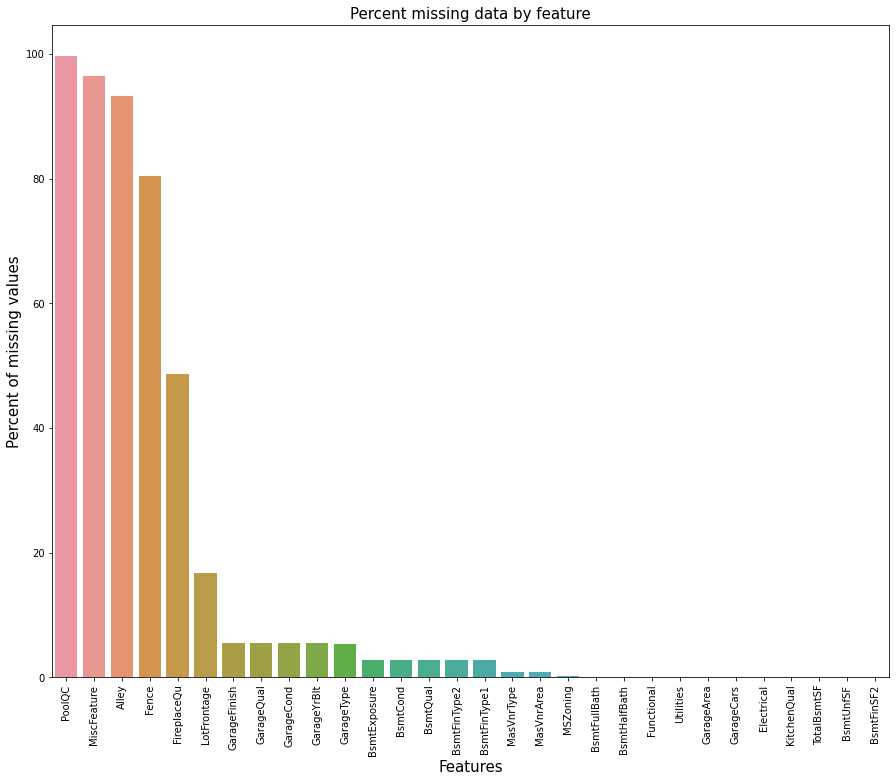

In [18]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation="90")
sns.barplot(y= all_data_na,x=all_data_na.index)
plt.xlabel("Features", fontsize=15)
plt.ylabel("Percent of missing values", fontsize=15)
plt.title("Percent missing data by feature", fontsize=15)
plt.show()

### 数据相关性

查看各个特征与标签的相关性

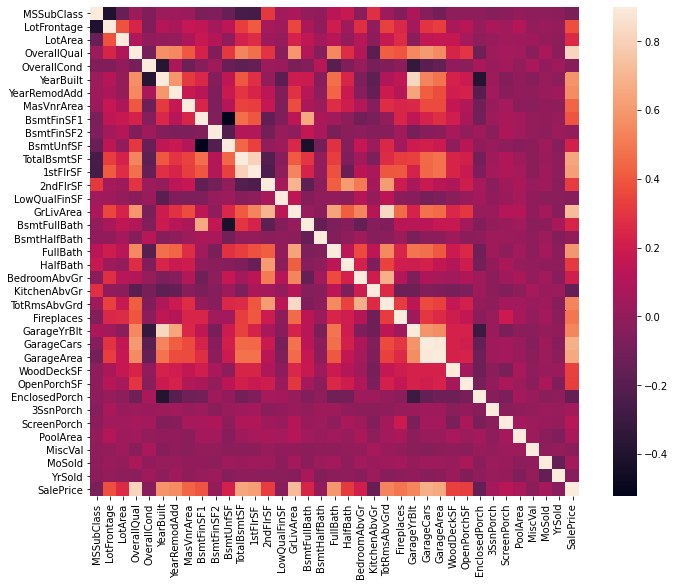

In [19]:
corrmat = train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True);

### 填补缺失值

PoolQC 游泳池

数据描述称NA的意思是没有游泳池。
考虑到缺失值的巨大比例（+99%），而且大多数房屋基本上没有泳池，这是有道理的。

In [20]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

MiscFeature 杂质特征

数据的缺数说明没有杂项特征（杂项特征是其他特征没有描述的，不统一的一些特征，比如说多出来的车库，篮球场等）。

In [21]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

Alley 胡同

数据的缺数说明没有通往物业的胡同

In [22]:
all_data["Alley"] = all_data["Alley"].fillna("None")

Fence 围栏

数据的缺失说明没有围栏

In [23]:
all_data["Fence"] = all_data["Fence"].fillna("None")

FireplaceQu 壁炉

数据的缺失说明没有壁炉

In [24]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

LotFrontage 与房产相邻的街道尺寸

与房产相邻街道的尺寸可能与相同地区其他的尺寸相似，我们可以用相邻地区的LotFrontage的中值来填补缺失值


In [25]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
lambda x:x.fillna(x.median()))

GarageType, GarageFinish, GarageQual and GarageCond 车库类型，车库内部装修，车库质量，车库条件

这些关于车库的离散值，缺失值我们用None表示

In [26]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna("None")

GarageYrBlt, GarageArea and GarageCars 车库好久修建的，车库面积（平方英尺），可容纳汽车数

缺失值可能说明根本就没有车库，这些连续值我们用0来填补

In [27]:
for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
    all_data[col] = all_data[col].fillna(0)

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath
地下室（ 类型1的完成面积，类型2的面积，未完工的面积，总面积，全浴室，半浴室）

这些有关地下室的连续值的缺失，可能说明没有地下室，所以用0替换缺失值

In [28]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 地下室（高度，条件，和花园连接墙的高度，完工评级，另外部分评级（可能未完工之类，与前面有点差别））

这些有关地下室的离散值的缺失，也可能说明没有地下室，所以可以用None来填补

In [29]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data.fillna("None")

MasVnrArea and MasVnrType 贴石砖类型，表层砌体类型

缺失值表示可能没有贴石砖

In [30]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

MSZoning 确定销售的分区

RL最多，缺失值可以用RL代替

In [31]:
all_data["MSZoning"] = all_data["MSZoning"].fillna(all_data["MSZoning"].mode()[0])

Utilities 可用的公共设施
对于这个分类特性，所有记录都是“AllPub”，除了一个“NoSeWa”和2个NA。

因为带有NoSewa的房子在训练集中，所以这个特性对预测建模没有帮助。然后我们就可以直接删除这个特征。

In [32]:
def feature_count(col):
    for i in all_data[col].unique():
        if str(i) != "nan":
            print(i, all_data[col][all_data[col]==i].count())
    print("miss values:",all_data[col].isnull().sum())

feature_count("Utilities")

AllPub 2914
NoSeWa 1
miss values: 2


In [33]:
all_data["Utilities"][all_data["Utilities"]=="NoSeWa"]

943    NoSeWa
Name: Utilities, dtype: object

In [34]:
all_data.drop("Utilities", axis=1,inplace=True)

Functional 家庭功能

默认值是Tpy,所以我们将缺失值填补为Tpy

In [35]:
all_data["Functional"].fillna("Typ", inplace=True)

Electrical 电气系统

这个缺失值只有一个，大多数值为SBrkr,所以讲缺失值填补为SBrkr

In [36]:
feature_count("Electrical")

SBrkr 2669
FuseF 50
FuseA 188
FuseP 8
Mix 1
miss values: 1


In [37]:
all_data["Electrical"].fillna(all_data["Electrical"].mode()[0], inplace=True)

KitchenQual 厨房品质

缺失值也只有一个，用最多的值填补

In [38]:
feature_count("KitchenQual")

Gd 1151
TA 1492
Ex 203
Fa 70
miss values: 1


In [39]:
all_data["KitchenQual"].fillna(all_data["KitchenQual"].mode()[0], inplace=True)

Exterior1st and Exterior2nd  房屋外部物品，额外房屋外部物品

同样缺失值不多我们用常见值替换

In [40]:
all_data["Exterior1st"].fillna(all_data["Exterior1st"].mode()[0], inplace=True)
all_data["Exterior2nd"].fillna(all_data["Exterior2nd"].mode()[0], inplace=True)

SaleType 销售类型

继续填补最多的值WD

In [41]:
feature_count("SaleType")

WD 2525
New 237
COD 87
ConLD 26
ConLI 9
CWD 12
ConLw 8
Con 5
Oth 7
miss values: 1


In [42]:
all_data["SaleType"].fillna(all_data["SaleType"].mode()[0], inplace=True)

In [43]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"Missing Ratio": all_data_na})
missing_data.head()

,Missing Ratio


没有返回值，意味着缺失值已经处理完了

## 更多特征工程

### 转换一些实际上是分类的数值型变量

In [44]:
# 建筑类型
all_data["MSSubClass"] = all_data["MSSubClass"].apply(str)

# 房子整体的材料和装饰评估
# 房子的整体状况
all_data["OverallQual"] = all_data["OverallQual"].apply(str)
all_data["OverallCond"] = all_data["OverallCond"].apply(str)

# 时间
all_data["YrSold"] = all_data["YrSold"].apply(str)
all_data["MoSold"] = all_data["MoSold"].apply(str)

### Label Encoding一些分类变量，它们的排序集中可能包含信息

注意Label Encoding和one hot以及get_dummies的区别

In [45]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

print(f"shape all_data:{all_data.shape}")

shape all_data:(2917, 78)


### 增加一项重要的特征

因为面积对于一个房子的价格来说是至关重要的，所以新增一个房子总面积的特征。 

In [46]:
all_data["TotalSF"] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### 特征偏态

In [47]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 检查所有数值型数据的偏态
skewed_feats = all_data[numeric_feats].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


### 偏态比较大的数据进行Box-Cox变换

In [48]:
skewness = skewness[abs(skewness) > 0.75]
print(f"这里有{skewness.shape[0]}个特征需要Box-Cox变换")

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

这里有58个特征需要Box-Cox变换


### Getting dummy 分类型变量

In [49]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 229)


### 得到新的训练集和测试集

In [50]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# 模型

### 导入模型

In [51]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

ElasticNet在我们发现用Lasso回归太过(太多特征被稀疏为0),而岭回归也正则化的不够(回归系数衰减太慢)的时候，可以考虑使用ElasticNet回归来综合，得到比较好的结果。
RobustScaler和StandardScaler比较近似，但是它并不是用均值和方差来进行转换，而是使用中位数和四分位矩。RobustScaler这种方法称为‘粗暴缩放’，它会直接把一些异常值踢出去，有点类似我们看体育节目中评委常说的‘去掉一个最高分，去掉一个最低分’这样的情况。

### 定义交叉验证策略

使用cross_val_score，然而这个函数没有打乱的功能，我们添加一行代码实现这个功能

In [52]:
n_folds = 5

# def rmsle_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
#     rmse = np.sqrt(-cross_val_score(model, train.values, y_trian, scoring="neg_mean_squared_error", cv=kf))
#     return (rmse)

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_trian, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### 基础模型

#### lasso回归
这个模型对异常值非常敏感，所以需要用RobustScaler()来"粗暴缩放"
所以在管道上使用RobustScaler()方法

In [53]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

#### 弹性网回归
对异常值也敏感

In [54]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#### 核岭回归

In [55]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#### 梯度提升回归 GBoost
使用hubei损失，是对异常值更稳定

In [56]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                  max_depth=4, max_features='sqrt',
                                  min_samples_leaf=15, min_impurity_split=10,
                                  loss='huber', random_state=5)

#### XGBoost

In [57]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [58]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                             learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [59]:
model_rfr = RandomForestRegressor(n_estimators=300, min_samples_leaf=2, random_state=420)

In [60]:
score = rmsle_cv(lasso)
print(f"Lasso score:{score.mean():.4f} ({score.std():.4f})")

Lasso score:0.1113 (0.0070)


In [61]:
score = rmsle_cv(ENet)
print(f"ElasticNet score:{score.mean():.4f} ({score.std():.4f})")

ElasticNet score:0.1112 (0.0070)


In [62]:
score = rmsle_cv(KRR)
print(f"Kernel score:{score.mean():.4f} ({score.std():.4f})")

Kernel score:0.1154 (0.0063)


In [63]:
score = rmsle_cv(GBoost)
print(f"GBoost score:{score.mean():.4f} ({score.std():.4f})")

GBoost score:0.3995 (0.0160)


In [64]:
score = rmsle_cv(model_xgb)
print(f"xgboost:{score.mean():.4f} ({score.std():.4f})")
# xgboost:0.1196 (0.0052)

[19:45:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:45:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

In [65]:
score = rmsle_cv(model_lgb)
print(f"LGBM score:{score.mean():.4f} ({score.std():.4f})")
# LGBM score:0.1178 (0.0054)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [66]:
score = rmsle_cv(model_rfr)
print(f"RandomForestRegressor:{score.mean():.4f} ({score.std():.4f})")

RandomForestRegressor:0.1377 (0.0058)


## Stacking models

### 简单叠加：平均叠加

定义一个均分基础模型类

In [67]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    # 预测，并返回平均结果
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

#### 平均模型得分

In [68]:
averaged_models = AveragingModels(models=(ENet, KRR, lasso, model_rfr))

In [69]:
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) 

 Averaged base models score: 0.1108 (0.0061)



In [70]:
avg = AveragingModels(models=(ENet, KRR, lasso, model_xgb, model_lgb))
avg.fit(train.values, y_trian)

[19:46:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Cu

AveragingModels(models=(Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('elasticnet',
                                         ElasticNet(alpha=0.0005, l1_ratio=0.9,
                                                    random_state=3))]),
                        KernelRidge(alpha=0.6, coef0=2.5, degree=2,
                                    kernel='polynomial'),
                        Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('lasso',
                                         Lasso(alpha=0.0005, random_state=1))]),
                        XGBRegressor(base_score=None, booster=None,
                                     colsample...
                                     reg_lambda=0.8571, scale_pos_weight=None,
                                     silent=1, subsample=0.5213,
                                     tree_method=None, validate_parameters=None,
                                     verbosit

In [71]:
pred = avg.predict(test.values)

In [72]:
sub = pd.DataFrame()
sub["Id"] = test_ID
sub["SalePrice"] = np.expm1(pred)
sub.to_csv("AveragingStackingModels.csv", index=False)

In [73]:
sub

,Id,SalePrice
0,1461,122561.992
1,1462,161186.567
2,1463,190412.029
3,1464,200224.191
4,1465,195097.379
...,...,...
1454,2915,88633.398
1455,2916,85727.868
1456,2917,171631.100
1457,2918,117470.935
